In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# download the dataset here: 
## https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line 

In [3]:
np.random.seed(410)

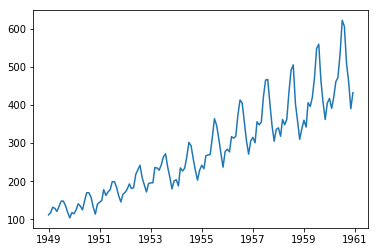

In [4]:
series = pd.read_csv('international-airline-passengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
plt.plot(series)
plt.show()

In [5]:
series.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60, dtype: int64

In [9]:
origin_values = series.values.astype('float32')

# normalize the values
scaler = MinMaxScaler(feature_range=(0,1))
origin_values = scaler.fit_transform(origin_values.reshape(-1,1))   # reshape(-1,1) here is important
origin_values[4:10]

array([[ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753]], dtype=float32)

In [10]:
train_size = int(len(origin_values)*0.67)
train, test = origin_values[0:train_size,:], origin_values[train_size:len(origin_values),:]
print len(train), len(test)
print train[4:10]

96 48
[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]


In [22]:
# dataX indicates time t, while dataY indicates time t+1
def shift_time(dataset, time_step):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step),0])
        dataY.append(dataset[i+time_step:(i+time_step*2),0])
    return np.array(dataX), np.array(dataY)

In [25]:
time_step = 1
trainX, trainY = shift_time(train, time_step)
testX, testY = shift_time(test, time_step)

print trainX[4:10]
print trainY[4:10]
print trainX.shape

[[ 0.03281853]
 [ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]]
[[ 0.05984557]
 [ 0.08494207]
 [ 0.08494207]
 [ 0.06177607]
 [ 0.02895753]
 [ 0.        ]]
(95, 1)


In [26]:
# reshape data into [samples, time_step, dimension], so that LSTM can read
## In this case, X, Y should be the same dimension, since Y is the sequence you want to predict from X

trainX = np.reshape(trainX, (trainX.shape[0], time_step, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], time_step, testX.shape[1]))

In [28]:
print trainX[4:10]
print testX[4:10]

[[[ 0.03281853]]

 [[ 0.05984557]]

 [[ 0.08494207]]

 [[ 0.08494207]]

 [[ 0.06177607]]

 [[ 0.02895753]]]
[[[ 0.48455599]]

 [[ 0.61389959]]

 [[ 0.69691122]]

 [[ 0.70077217]]

 [[ 0.57915056]]

 [[ 0.46911195]]]


In [31]:
trainX.shape[1:]

(1, 1)

In [32]:
# LSTM model

model = Sequential()
model.add(LSTM(4, input_shape=trainX.shape[1:]))  # LSTM just want (time_stem, dimension) as input_shape
model.add(Dense(1))  # single output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2,
         validation_data=(testX, testY))

Train on 95 samples, validate on 47 samples
Epoch 1/100
1s - loss: 0.0328 - val_loss: 0.1836
Epoch 2/100
0s - loss: 0.0150 - val_loss: 0.1219
Epoch 3/100
0s - loss: 0.0123 - val_loss: 0.1048
Epoch 4/100
0s - loss: 0.0115 - val_loss: 0.0894
Epoch 5/100
0s - loss: 0.0107 - val_loss: 0.0869
Epoch 6/100
0s - loss: 0.0100 - val_loss: 0.0771
Epoch 7/100
0s - loss: 0.0091 - val_loss: 0.0699
Epoch 8/100
0s - loss: 0.0083 - val_loss: 0.0627
Epoch 9/100
0s - loss: 0.0074 - val_loss: 0.0569
Epoch 10/100
0s - loss: 0.0066 - val_loss: 0.0438
Epoch 11/100
0s - loss: 0.0059 - val_loss: 0.0374
Epoch 12/100
0s - loss: 0.0051 - val_loss: 0.0308
Epoch 13/100
0s - loss: 0.0045 - val_loss: 0.0297
Epoch 14/100
0s - loss: 0.0039 - val_loss: 0.0224
Epoch 15/100
0s - loss: 0.0035 - val_loss: 0.0197
Epoch 16/100
0s - loss: 0.0031 - val_loss: 0.0159
Epoch 17/100
0s - loss: 0.0028 - val_loss: 0.0137
Epoch 18/100
0s - loss: 0.0025 - val_loss: 0.0120
Epoch 19/100
0s - loss: 0.0024 - val_loss: 0.0116
Epoch 20/100
0s

In [34]:
# make prediction

train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_RMSE = math.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0]))
print 'Train RMSE: %.7f' % (train_RMSE)
test_RMSE = math.sqrt(mean_squared_error(testY[:,0], test_predict[:,0]))
print 'Test RMSE: %.7f' % (test_RMSE)

Train RMSE: 0.0448689
Test RMSE: 0.0961093


In [38]:
print train_predict[4:10]
print origin_values.shape
print train_predict.shape
print test_predict.shape

[[ 0.04352542]
 [ 0.06731319]
 [ 0.08974937]
 [ 0.08974937]
 [ 0.06902762]
 [ 0.04016114]]
(144, 1)
(95, 1)
(47, 1)


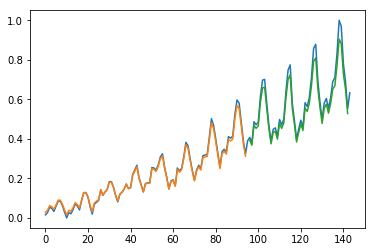

In [47]:
# plot the prediction

train_predict_plot = np.empty_like(origin_values)
train_predict_plot[:, :] = np.nan
train_predict_plot[0:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(origin_values)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+time_step:len(origin_values)-1, :] = test_predict

plt.plot(origin_values)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [46]:
origin_values

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753],
       [ 0.        ],
       [ 0.02702703],
       [ 0.02123553],
       [ 0.04247104],
       [ 0.07142857],
       [ 0.05984557],
       [ 0.04054055],
       [ 0.08687258],
       [ 0.12741312],
       [ 0.12741312],
       [ 0.10424709],
       [ 0.05598456],
       [ 0.01930502],
       [ 0.06949806],
       [ 0.07915059],
       [ 0.08880308],
       [ 0.14285713],
       [ 0.11389962],
       [ 0.13127413],
       [ 0.14285713],
       [ 0.18339768],
       [ 0.18339768],
       [ 0.15444016],
       [ 0.11196911],
       [ 0.08108109],
       [ 0.1196911 ],
       [ 0.12934363],
       [ 0.14671814],
       [ 0.17181468],
       [ 0.14864865],
       [ 0.15250966],
       [ 0.22007722],
       [ 0.24324325],
       [ 0.26640925],
       [ 0.2027027 ],
       [ 0